In [2]:
#import important modules
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
import math as mth
from PIL import Image, ImageDraw
import seaborn as sns

## Visualize landmarks ##

* Plot landmark positions for respective images.
* Visualize tangents to the landmarks

../boostnet_labeldata/data/training/sunhl-1th-02-Jan-2017-162 A AP.jpg
(2125, 755, 3)
[0]
[0.47815  0.66623  0.4649   0.6596   0.46358  0.63841  0.4543   0.61854
 0.45828  0.62517  0.44238  0.61325  0.44901  0.60132  0.42649  0.59603
 0.41987  0.61457  0.40132  0.59073  0.40265  0.56424  0.3894   0.5457
 0.38675  0.56159  0.33377  0.50066  0.31126  0.48212  0.25563  0.4649
 0.21987  0.43576  0.2053   0.43046  0.22384  0.43709  0.25695  0.4755
 0.26887  0.48212  0.32053  0.54172  0.37616  0.55894  0.42781  0.63046
 0.44503  0.66093  0.50199  0.7457   0.51391  0.7457   0.54305  0.76954
 0.51656  0.7351   0.50728  0.75894  0.46093  0.73113  0.42781  0.69536
 0.38543  0.67417  0.38146  0.63444  0.033882 0.034824 0.051765 0.055059
 0.080471 0.081882 0.098353 0.10871  0.12141  0.12941  0.14965  0.15482
 0.16376  0.16565  0.18306  0.18776  0.19247  0.19859  0.22306  0.23106
 0.23718  0.24518  0.27247  0.28141  0.28329  0.29741  0.31435  0.336
 0.328    0.34541  0.36706  0.384    0.38824  0.39

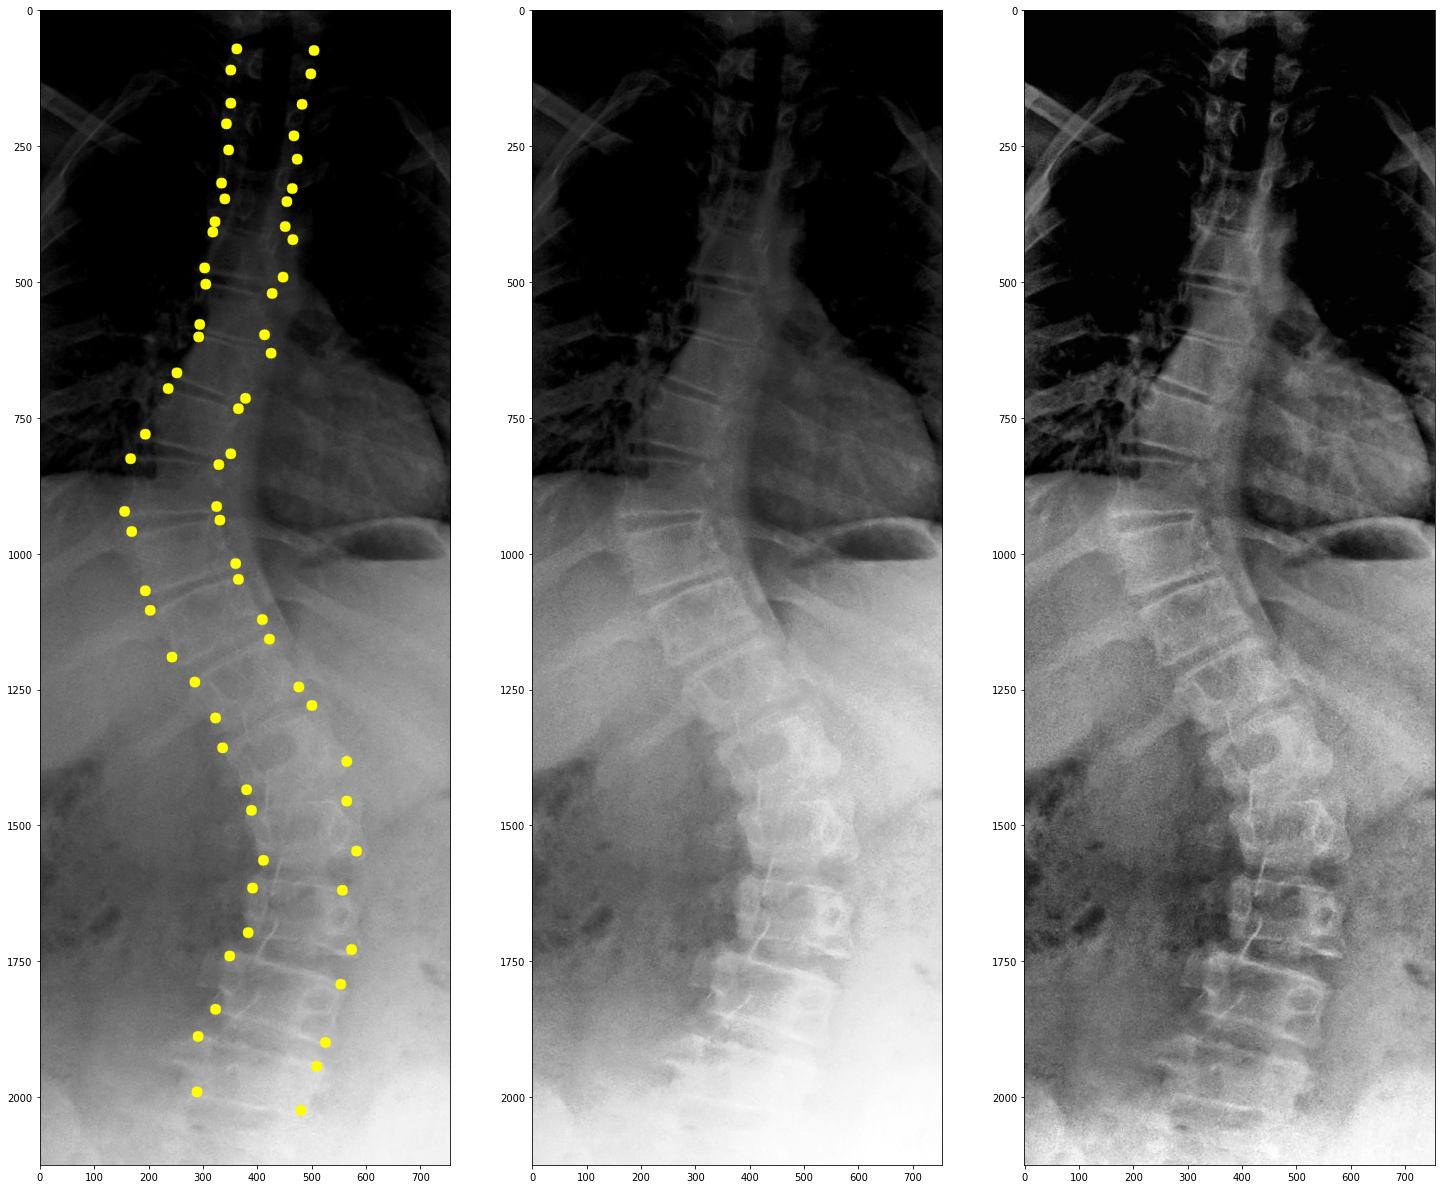

In [2]:

filename = "sunhl-1th-02-Jan-2017-162 A AP.jpg"
#image_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/data/training/"
#label_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/labels/training/"
image_directory="../boostnet_labeldata/data/training/"
label_directory="../boostnet_labeldata/labels/training/"
image = image_directory+filename

print (image_directory+filename)
img = cv2.imread(image)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(gray)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)

print (img.shape)
indx = filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
print(indx)
landmark= data.iloc[indx[0]].values
print (landmark)
cnt=[]
for m in range(0,68):
    cv2.circle(img,(int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])), 10, (0,255,255), -1)

    
#gnu
plt.figure(1, figsize=(25,25))


plt.subplot(131)
plt.imshow(img[:,:,::-1])

plt.subplot (132)
plt.imshow(equ, cmap= cm.gray)

plt.subplot (133)
plt.imshow(cl1, cmap= cm.gray)


In [3]:
def find_cobb_angles(vertebra_slopes):
    
    cobb_angles= [0.0,0.0,0.0]
    if not isinstance(vertebra_slopes, np.ndarray):
        vertebra_slopes= np.array(vertebra_slopes)
    
    max_slope = np.amax(vertebra_slopes)
    min_slope= np.amin(vertebra_slopes)
    
    lower_MT= np.argmax(vertebra_slopes)
    upper_MT = np.argmin(vertebra_slopes)
    
    if lower_MT < upper_MT:
        lower_MT, upper_MT = upper_MT, lower_MT
    

    upper_max_slope= np.amax(vertebra_slopes[0:upper_MT+1])
    upper_min_slope = np.amin(vertebra_slopes[0:upper_MT+1])

    lower_max_slope=np.amax(vertebra_slopes[lower_MT:17])
    lower_min_slope=np.amin(vertebra_slopes[lower_MT:17])


    cobb_angles[0]= abs(np.rad2deg(np.arctan(max_slope))- np.rad2deg(np.arctan(min_slope)))
    cobb_angles[1]= abs(np.rad2deg(np.arctan(upper_max_slope))-np.rad2deg(np.arctan(upper_min_slope)))
    cobb_angles[2]= abs(np.rad2deg(np.arctan(lower_max_slope)) - np.rad2deg(np.arctan(lower_min_slope)))
    
    return cobb_angles
    
    

In [4]:
def make_csv_cobb_angles(image_directory, filenames_csv, landmarks_csv, split_type= 'training'):
    
    landmarks_data= pd.read_csv(landmarks_csv,header= None)
    filename_labels= pd.read_csv(filenames_csv,header= None)
    
    df= pd.DataFrame(columns=['image_id', 'MT','PT','TL'])

    
    for i, names in enumerate(filename_labels.iloc[:,0]):
        
        img = cv2.imread(image_directory+names)
        landmarks = landmarks_data.loc[i].values
        avg_slopes=[]
        for m in range (0,68,4):
            slope1 = (round(img.shape[0]*landmarks[m+1+68])-round(img.shape[0]*landmarks[m+68]))/(
                     round(img.shape[1]*landmarks[m+1])-round(img.shape[1]*landmarks[m]))
            slope2 = (round(img.shape[0]*landmarks[m+3+68])-round(img.shape[0]*landmarks[m+2+68]))/(
                    round(img.shape[1]*landmarks[m+3])-round(img.shape[1]*landmarks[m+2]))
            avg_slopes.append((slope1+slope2)/2)
        cobb_angles= find_cobb_angles(avg_slopes)
        print (cobb_angles)
        df= df.append({'image_id': names, 'MT': cobb_angles[0],
                       'PT': cobb_angles[1],'TL': cobb_angles[2]}, ignore_index=True)
        csv_file= split_type + "_cobb_angles"+".csv"
        df.to_csv(csv_file,index= False)

In [5]:
train_data_directory = "../boostnet_labeldata/data/training/"
test_data_directory = "../boostnet_labeldata/data/test/"
train_label_directory= "../boostnet_labeldata/labels/training/"
test_label_directory = "../boostnet_labeldata/labels/test/"

make_csv_cobb_angles(train_data_directory, train_label_directory + 'filenames.csv',
         train_label_directory + 'landmarks.csv', 'training')

make_csv_cobb_angles(test_data_directory, test_label_directory + 'filenames.csv',
         test_label_directory + 'landmarks.csv', 'test')

[41.465431505588526, 14.730911293561544, 40.39509002053023]
[59.21972335622007, 51.55087892224279, 9.313091276541856]
[32.857459435757214, 9.40398602177208, 0.0]
[34.22557744747068, 16.132338532389653, 6.632593537227825]
[17.96277759330011, 7.020854262611232, 7.206376673761797]
[47.42111916501626, 41.691698540896425, 13.573862312901925]
[33.14276309333513, 28.902168032744935, 15.59327083877308]
[26.225510642750354, 20.905653632108226, 16.293468746530333]
[79.38906215975926, 35.707361466670186, 42.02333179831319]
[58.472876267665384, 27.129874346679117, 8.489065769088256]
[56.67168239271593, 17.00680688271213, 38.38965304789023]
[23.59697652900983, 22.45182393050334, 6.405316853664533]
[31.592548330843893, 21.012389361209173, 4.546519250912429]
[45.82439430210529, 17.75764764253456, 38.79366020865111]
[52.503938826347564, 16.617255571137797, 41.95884565186291]
[14.631893746389082, 2.41866650465923, 5.483916328743173]
[8.728704223299014, 2.0103736528005065, 1.7603098480280095]
[10.635049

[42.432383759647436, 20.784444192956272, 28.872260327031018]
[33.85436487239022, 14.375406653817802, 18.008817554189296]
[65.59204943476233, 25.52352100361234, 60.45546925354226]
[59.968006755078804, 10.067014596205347, 49.101636445421704]
[62.37857422754744, 18.952789308872823, 43.48147183468619]
[51.57754826371175, 11.735980769831396, 31.50248161084673]
[27.70435148538708, 24.79041568482861, 9.995283149658066]
[27.275339778951647, 23.814931018199573, 6.627129476028654]
[23.55691022612415, 23.398547142533243, 0.0]
[28.747217757307595, 26.90692080658939, 3.098028328779021]
[25.405724417147997, 22.499364242105564, 10.440238466809532]
[14.98765305223345, 7.3751241036664705, 9.170718175054816]
[35.892055865653305, 1.613465232695301, 26.43234551728427]
[39.906323049944035, 0.0, 25.108837772976475]
[37.4979037051953, 28.981690867553922, 28.347677413505366]
[28.35086853411724, 21.58384825684423, 23.997180922829656]
[34.541749905266194, 19.09173242487913, 22.13676809811579]
[18.86538724073671

[46.75037971918149, 13.815130508374946, 1.7811765954459986]
[40.63301681948467, 12.554937022792986, 3.0278975108739132]
[39.83249154135831, 13.284774867500317, 1.0976502231440861]
[26.206088664845602, 19.431034550094925, 0.0]
[19.869018723530303, 12.774934755921617, 3.9720344863924355]
[42.55393945912223, 10.624437546309736, 35.992765394806916]
[30.684490250560202, 8.58083025890355, 22.325109501222077]
[33.65173446609545, 12.621967539808775, 19.39540158207669]
[76.89979446284758, 43.74594816896283, 39.50577301414874]
[73.83221891509646, 25.888234448114254, 15.134579619032657]
[69.13863388793717, 18.926654925580316, 16.087205656046503]
[54.708661531692655, 24.817315582256068, 49.01335770878208]
[57.81988162885274, 26.72291071020054, 44.56180618209104]
[27.15926916659697, 10.535324362702251, 25.631548209135087]
[31.9234415665767, 23.02664490735131, 3.997970852020819]
[34.34294391768421, 27.37892554922744, 12.975382784392249]
[25.62192160319492, 21.860907966502253, 17.70764513651124]
[36.

[34.74402698306359, 18.942941775314914, 12.380114712756926]
[11.406383058272015, 0.0, 9.129920246858708]
[17.817218304807376, 8.242911218395593, 13.473928985994686]
[40.7086505776624, 24.57812544163529, 6.711614911315021]
[29.127714265423506, 17.424709097249455, 0.8158172097060632]
[36.00143453777462, 20.91788196098737, 6.4663677645139295]
[43.597434635508186, 40.468489294755344, 15.118741645830738]
[55.57902027604787, 15.465900233428872, 41.1084416689496]
[58.15302503572695, 7.609523194438278, 46.69246493678979]
[42.00426840275076, 26.13967468375056, 7.666363056980913]
[37.42047333187609, 8.068865431231007, 37.208478122368]
[39.53034801225925, 8.95385288067258, 39.253674465594486]
[22.32099926317793, 10.628403623802757, 21.692954695222433]
[28.47798722507534, 6.068425218047, 12.765680321636676]
[66.33302271733938, 32.83115797870014, 28.11766942993537]
[39.02147762017679, 38.76562252743048, 6.804133764443753]
[33.35109283691425, 22.649249413973685, 31.51214975722458]
[49.40543792727874

[20.111612090222707, 17.65434633585601, 19.634324576897107]
[20.414897864881496, 15.745183723827042, 20.051807287380335]
[20.60584692015353, 15.811794598393265, 20.554937992691084]
[25.64342912273185, 18.74271506825936, 18.31214378046242]
[22.245586092728026, 18.00782831554322, 19.72098454998243]
[28.592457123112474, 23.302851267241344, 21.821713602092657]
[33.63637274379618, 27.288698859066834, 22.73005799751996]
[33.594129692542566, 27.690036923425648, 26.642074711060282]
[37.56143248898536, 26.61583094387239, 29.550486434470074]
[11.611857996938136, 9.703387154471342, 5.761891318693333]
[19.20094378178877, 3.0789983990070446, 7.812687962416158]
[19.325136382163556, 18.330795460433336, 9.769496335302636]
[18.978165380555527, 10.443421705695293, 16.679073500521717]
[41.80133074665413, 17.283476189543137, 22.890048641940012]
[24.36200609761914, 15.029389654176468, 5.738098487688598]
[19.705815503677936, 13.746118738298017, 5.177023742779022]
[39.98918938863989, 18.14403288229524, 18.56

[0.03085177733065057, 0.10007331378299121, 0.11009597637504615, 0.056453804347826084, 0.10365824651538938, 0.15018060572381214, 0.29617604617604615, 0.25733490334608966, 0.0073980512450378955, -0.21673254281949933, -0.383605459887678, -0.46561523159988627, -0.37750066684449185, -0.10120300751879699, 0.09673046251993621, 0.2759658318773054, 0.21515202459291993]
Maximum Tilted vertebra 6 11
 Their Slopes:  [0.03085177733065057, 0.10007331378299121, 0.11009597637504615, 0.056453804347826084, 0.10365824651538938, 0.15018060572381214, 0.29617604617604615]
Upper max-min slopes:  0.29617604617604615 0.03085177733065057
Lower max-min slopes:  0.2759658318773054 -0.46561523159988627
16.498027401340373 1.767116107778829
 Cobb angles [41.465431505588526, 14.730911293561544, 40.39509002053023]


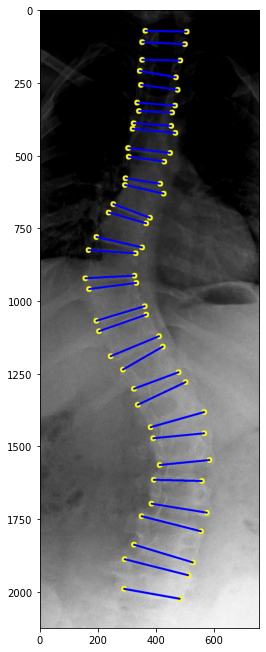

In [6]:
slopes =[]
avg_slopes=[]
lines = []
cobb_angles= [0.0,0.0,0.0]
for m in range (0,68,2):
    slope = (round(img.shape[0]*landmark[m+1+68])-round(img.shape[0]*landmark[m+68]))/(round(img.shape[1]*landmark[m+1])-round(img.shape[1]*landmark[m]))
    #print (landmark[m+68])
    slopes.append(slope)
    lines.append(((int(img.shape[1]*landmark[m+1]),int(img.shape[0]*landmark[m+1+68])),(int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68]))))

for s in range (0,34,2):
    avg_slopes.append((slopes[s]+slopes[s+1])/2)

avg_slope = np.array(avg_slopes)
max_slope = np.amax(avg_slopes)
min_slope= np.amin(avg_slopes)
if np.argmax(avg_slopes)> np.argmin(avg_slopes):
    lower_MT= np.argmax(avg_slopes)
    upper_MT = np.argmin(avg_slopes)
else:
    upper_MT= np.argmax(avg_slopes)
    lower_MT = np.argmin(avg_slopes)

#upper_MT= np.argmax(avg_slopes)
#lower_MT = np.argmin(avg_slopes)    
print (avg_slopes)
print ("Maximum Tilted vertebra",upper_MT,lower_MT)
print (" Their Slopes: ", avg_slopes[0:upper_MT+1])

    
upper_max_slope= np.amax(avg_slopes[0:upper_MT+1])
upper_min_slope = np.amin(avg_slopes[0:upper_MT+1])


lower_max_slope=np.amax(avg_slopes[lower_MT:17])
lower_min_slope=np.amin(avg_slopes[lower_MT:17])

print ("Upper max-min slopes: ", upper_max_slope, upper_min_slope)
print ("Lower max-min slopes: ",lower_max_slope, lower_min_slope)
print (np.rad2deg(np.arctan(upper_max_slope)), np.rad2deg(np.arctan(upper_min_slope)))

cobb_angles[0]= abs(np.rad2deg(np.arctan(max_slope))- np.rad2deg(np.arctan(min_slope)))
cobb_angles[1]= abs(np.rad2deg(np.arctan(upper_max_slope))-np.rad2deg(np.arctan(upper_min_slope)))
cobb_angles[2]= abs(np.rad2deg(np.arctan(lower_max_slope)) - np.rad2deg(np.arctan(lower_min_slope)))




[cv2.line (img,pt[0],pt[1],(255,0,0),5) for pt in lines]


#for l in lines:
#    print (l[0],l[1])

plt.figure(1, figsize=(25,25))

plt.subplot(211)
plt.imshow(img[:,:,::-1])


print (" Cobb angles", cobb_angles)
    

# Generate GroundTruth For Segmentation #

Connects all the landmark points to generate a snake-like curve. This segmented curve is used as groundtruth to train image segmentation models like U-net.

(2614, 1141, 3)
[0.43909  0.57581  0.44172  0.56968  0.43646  0.56617  0.43032  0.55653
 0.42857  0.5539   0.42244  0.53812  0.41718  0.52498  0.40578  0.50482
 0.38738  0.48904  0.34882  0.45223  0.33041  0.44172  0.28396  0.3979
 0.28396  0.38826  0.25592  0.37511  0.25416  0.37248  0.25855  0.37862
 0.26643  0.38563  0.28571  0.41455  0.30237  0.4312   0.34531  0.48203
 0.37423  0.50394  0.4128   0.57055  0.43909  0.5837   0.47415  0.62138
 0.47765  0.63453  0.52585  0.66959  0.52498  0.68098  0.52147  0.68449
 0.52235  0.68536  0.51183  0.66258  0.48203  0.64417  0.42682  0.6021
 0.38913  0.58808  0.38124  0.57493  0.071538 0.072303 0.091048 0.096787
 0.10214  0.1075   0.12663  0.13007  0.13657  0.14614  0.15647  0.17024
 0.17024  0.18592  0.20161  0.215    0.21385  0.22992  0.24981  0.26473
 0.26358  0.27621  0.29763  0.31331  0.30987  0.32249  0.35004  0.35501
 0.36266  0.36496  0.40742  0.39977  0.42043  0.41086  0.46174  0.4407
 0.47666  0.45409  0.51836  0.48852  0.52946  0.5 

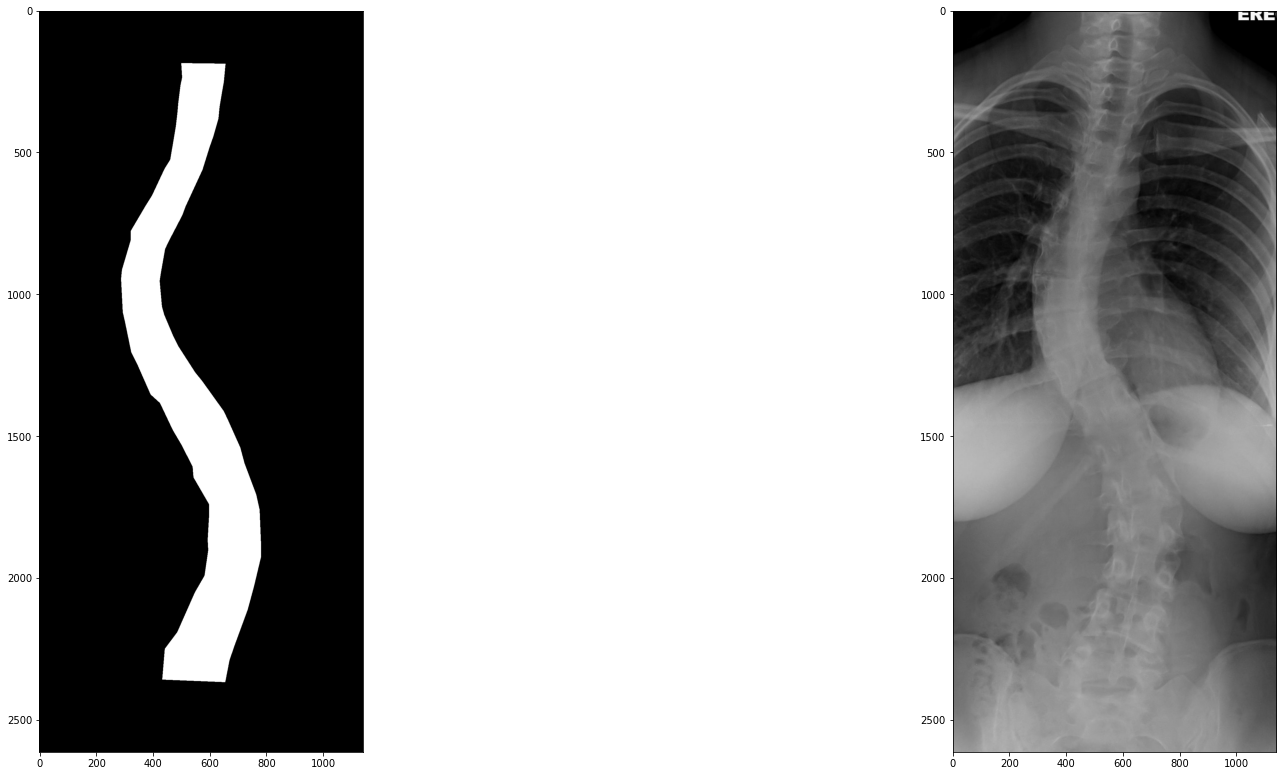

In [7]:
filename = "sunhl-1th-01-Mar-2017-310 C AP.jpg"
image_directory= "../boostnet_labeldata/data/test/"
label_directory= "../boostnet_labeldata/labels/test/"
image = image_directory+filename


img = cv2.imread(image)
data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)
print (img.shape)

# extract landmarks
indx= filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
landmark= data.iloc[indx[0]].values
print (landmark)
cnt=[]

# take second element for sort
def takeSecond(elem):
    return elem[1]

# convert landmarks to image coordinates
left_side_coordinates=[[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (0,68,2)]
right_side_coordinates= [[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (67,0,-2)]

#sort the elements for continuous boundary
left_side_coordinates.sort(key=takeSecond)
right_side_coordinates.sort(key=takeSecond,reverse=True)
cnt=left_side_coordinates+right_side_coordinates

    

empty_image = np.zeros(img.shape,np.uint8)
cnt= np.array(cnt)
#print (cnt)

cv2.drawContours(empty_image,[cnt],-1,(255,255,255),-1)
plt.figure(1, figsize=(30,30))

plt.subplot(221)
plt.imshow(empty_image,cmap=cm.gray)

plt.subplot(222)
plt.imshow(img[:,:,::-1])

## Generate Ground Truth for Combined Landmarks detection ##

(2125, 755, 3)
93.40504459039845


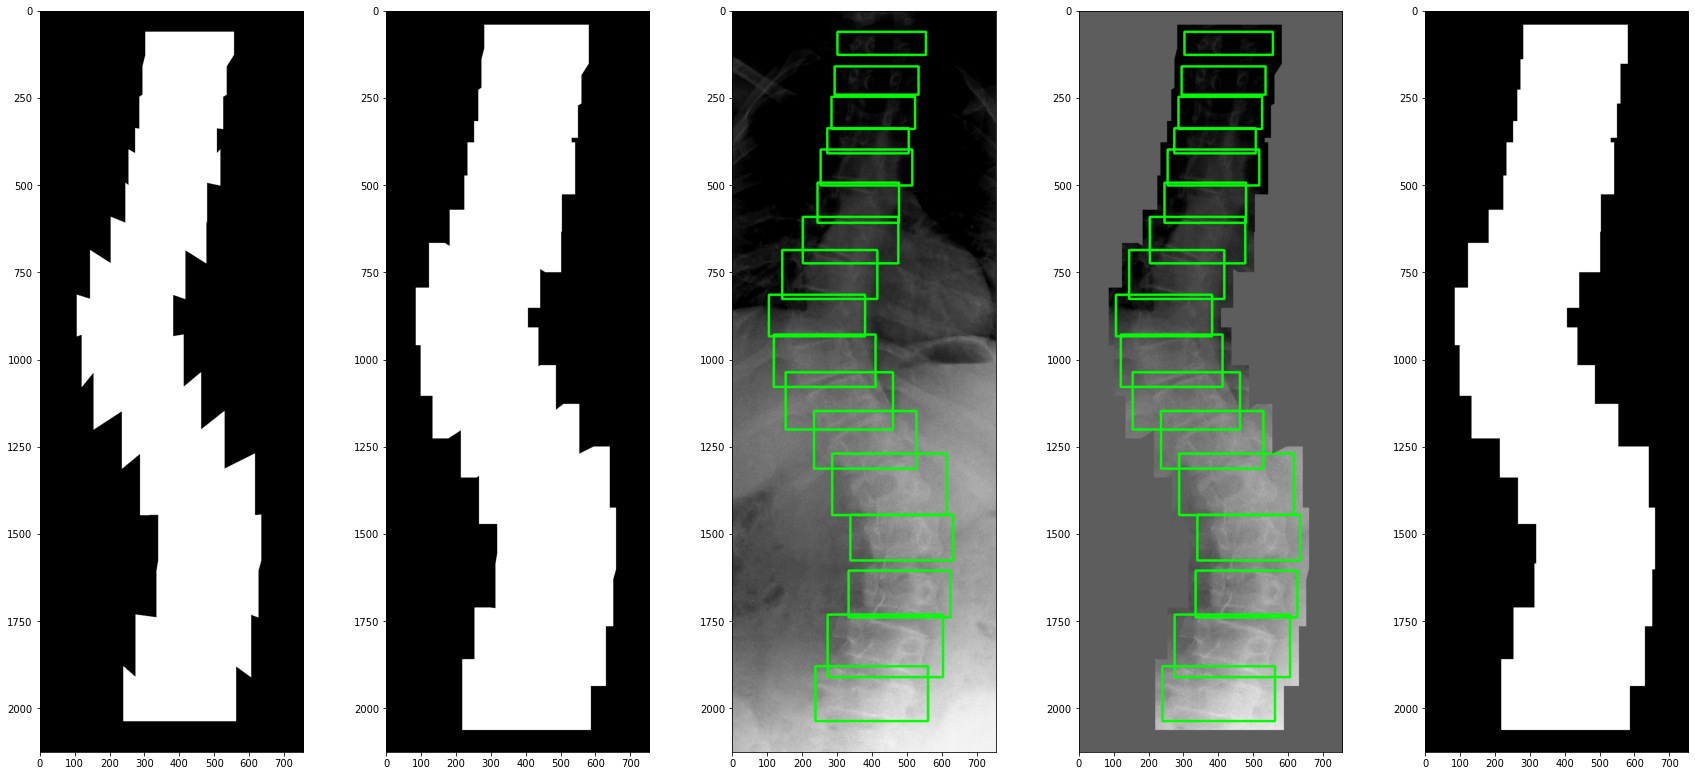

In [8]:
filename = "sunhl-1th-02-Jan-2017-162 A AP.jpg"
image_directory= "../boostnet_labeldata/data/training/"
label_directory= "../boostnet_labeldata/labels/training/"
image = image_directory+filename


img = cv2.imread(image)
data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)
print (img.shape)



# extract landmarks
indx= filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
landmarks= data.iloc[indx[0]].values



landmark = [[int(round(img.shape[1]*landmarks[m])),int(round(img.shape[0]*landmarks[m+68]))] for m in range (0,68)]

# group 4 corner landmarks to form box
N=4    
landmark_corners = [landmark[n:n+N] for n in range(0, len(landmark), N)]
landmark_corners= np.array(landmark_corners)
boxes= []

###### first method to segment spine 
blank_image= np.zeros(img.shape,np.uint8)
for box in landmark_corners:
    x,y,w,h = cv2.boundingRect(box)
    boxes.append([x-50,y-10,x+w+50,y+h+10])
    cv2.rectangle(img,(x-50,y-10),(x+w+50,y+h+10),(0,255,0),5)
    cv2.rectangle(blank_image,(x-50,y-10),(x+w+50,y+h+10),(255,255,255),-1)
    
kernel = np.ones((10,10),np.uint8)
blank_image = cv2.dilate(blank_image,kernel,iterations = 5)




##### second method to segment spine

boxes.sort(key=lambda x: x[1])
box_corners= []
box_corners_right_side=[]
box_corners_left_side=[]
for bb in boxes:
    top_left= bb[0:2]
    top_right= [bb[2],bb[1]]
    bottom_left=[bb[0],bb[3]]
    bottom_right=bb[2:4]
    box_corners.append([top_left,top_right,bottom_left,bottom_right])
    box_corners_left_side.append([top_left,bottom_left])
    box_corners_right_side.append([top_right,bottom_right])

box_corners_left_side=np.array( box_corners_left_side).reshape((17*2,2)).tolist()
box_corners_right_side= np.array(box_corners_right_side).reshape((17*2,2)).tolist()


# take second element for sort
def takeSecond(elem):
    return elem[1]



cnt= box_corners_left_side + box_corners_right_side[::-1]
cnt=np.array(cnt)

# create black image of img size
empty_image = np.zeros(img.shape,np.uint8)
binary_image= np.copy(empty_image)


cv2.drawContours(binary_image,[cnt],-1,(255,255,255),-1)
kernel = np.ones((10,10),np.uint8)

masked_img=np.copy(img)
dilated = cv2.dilate(binary_image,kernel,iterations = 5)
#masked_image = cv2.bitwise_and(img,blank_image) 

#makk= np.array([255,0,0])
#boll_mak= ~makk.astype(bool)
#print (boll_mak)
masked = np.ma.array(data= img, mask= ~dilated.astype(bool))
mean= np.mean(masked)
print (mean)
masked_img[dilated==0] = mean
#pixelpoints = masked_image[~np.all(masked_image == 0, axis=2)]


plt.figure(1, figsize=(30,30))

plt.subplot(251)
plt.imshow(binary_image,cmap=cm.gray)

plt.subplot(252)
plt.imshow(dilated,cmap=cm.gray)


plt.subplot(253)
plt.imshow(img[:,:,::-1])

plt.subplot(254)
plt.imshow(masked_img[:,:,::-1])

plt.subplot(255)
plt.imshow(blank_image, cmap=cm.gray)

## Generate segmentation ground for all images and save ##

Connects all the landmark points to generate a snake-like curve. This segmented curve is used as groundtruth to train image segmentation models like U-net.

In [9]:

# take second element for sort
def takeSecond(elem):
        return elem[1]

image_directory= "../boostnet_labeldata/data/test/"
label_directory= "../boostnet_labeldata/labels/test/"
ground_truth= "groundtruth for 68 landmarks detection/test/"
data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)

i=0
for names in filename_labels.iloc[:,0]:

    img = cv2.imread(image_directory+names)
    #print (img.shape)
    landmark = data.loc[i].values
    #print (landmark)
    cnt=[]

    # convert landmarks to image coordinates
    left_side_coordinates=[[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (0,68,2)]
    right_side_coordinates= [[int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])] for m in range (67,0,-2)]

    #sort the elements for continuous boundary
    left_side_coordinates.sort(key=takeSecond)
    right_side_coordinates.sort(key=takeSecond,reverse=True)
    cnt=left_side_coordinates+right_side_coordinates


    gnd_image = np.zeros(img.shape,np.uint8)
    cnt= np.array(cnt)

    cv2.drawContours(gnd_image,[cnt],-1,(255,255,255),-1)
    i+=1
    if not os.path.exists(ground_truth):
        os.makedirs(ground_truth)
    cv2.imwrite(ground_truth+names,gnd_image)

### Find the Z-score of boudning boxes' width and height separately

[188.58823529 118.05882353]
[31.39887376 34.69950091]


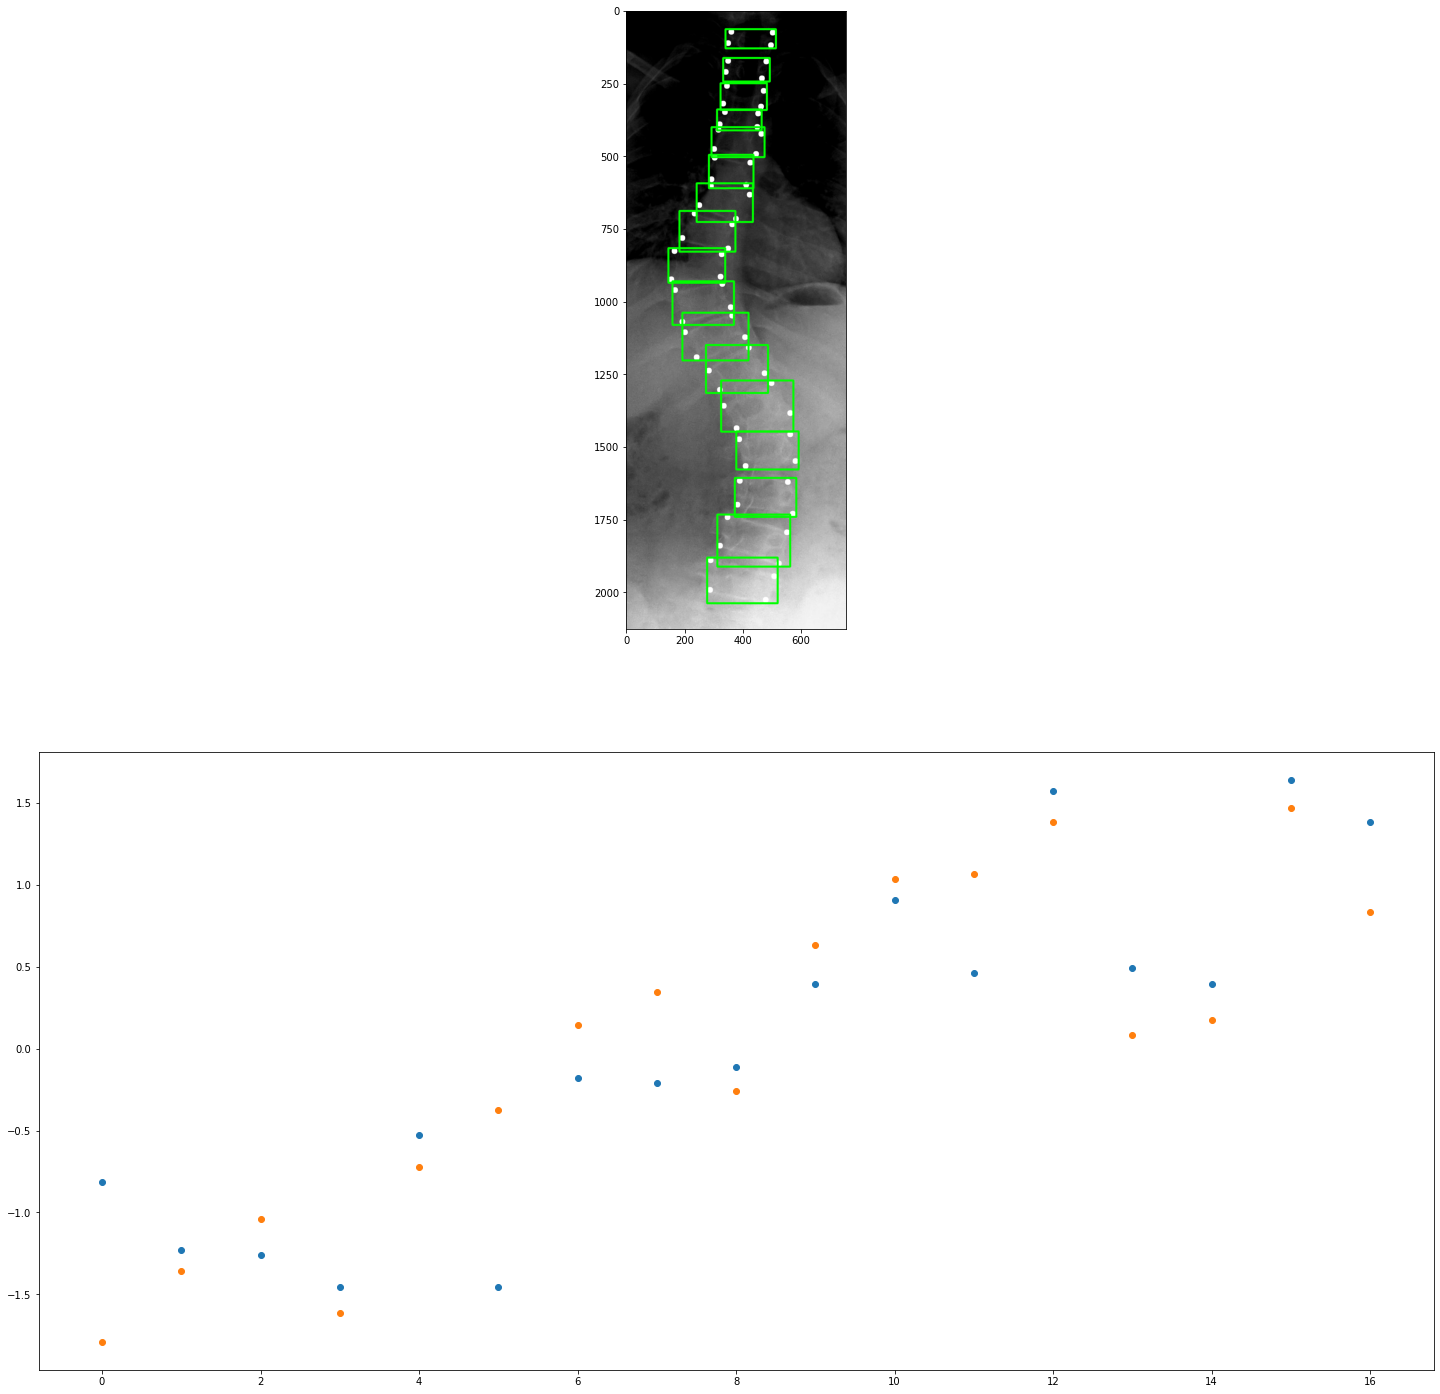

In [10]:

def zscore(bboxes):
    mean= np.mean(bboxes,axis= 0)
    std =np. std(bboxes,axis=0)
    z_score= (bboxes-mean)/std
    return z_score

filename = "sunhl-1th-02-Jan-2017-162 A AP.jpg"
#image_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/data/training/"
#label_directory= "C:/Users/Brinda Khanal/Downloads/scoliosis xray Single View/boostnet_labeldata/labels/training/"
image_directory= "../boostnet_labeldata/data/training/"
label_directory= "../boostnet_labeldata/labels/training/"
image = image_directory+filename


img = cv2.imread(image)

data= pd.read_csv(label_directory+"landmarks.csv",header= None)
filename_labels= pd.read_csv(label_directory+"filenames.csv",header= None)


indx= filename_labels[filename_labels.iloc[:,0]== filename].index.tolist()
landmark= data.iloc[indx[0]].values
for m in range(0,68):
    cv2.circle(img,(int(img.shape[1]*landmark[m]),int(img.shape[0]*landmark[m+68])), 10, (255,255,255), -1)

landmark = [[int(round(img.shape[1]*landmark[m])),int(round(img.shape[0]*landmark[m+68]))] for m in range (0,68)]
#print (landmark)


N=4    
corners = [landmark[n:n+N] for n in range(0, len(landmark), N)]
corners= np.array(corners)

bboxes=[]
for box in corners:
    x,y,w,h = cv2.boundingRect(box)    
    cv2.rectangle(img,(x-10,y-10),(x+w+10,y+h+10),(0,255,0),5)
    bboxes.append((w+10,h+10))
    

    
print (np.mean(bboxes,axis=0))
print (np.std(bboxes,axis=0))
Z_score = zscore(bboxes)
#print (Z_score)


plt.figure(1, figsize=(25,25))




#print (Z_score.shape[0],Z_score[1])
#print (Z_score[:,0])

plt.subplot(211)
plt.imshow(img[:,:,::-1])

plt.subplot (212)
plt.scatter( x=np.arange(Z_score.shape[0]), y= Z_score[:,0], alpha=1)
plt.scatter( x=np.arange (Z_score.shape[0]),y= Z_score[:,1], alpha=1)
plt.show()


In [11]:
def zscore(bboxes):
    mean= np.mean(bboxes,axis= 0)
    std =np. std(bboxes,axis=0)
    z_score= (bboxes-mean)/std
    return z_score

In [12]:
def bbox_zscore(image_directory, filenames_csv, landmarks_csv, split_type= 'training'):
    
    landmarks_data= pd.read_csv(landmarks_csv,header= None)
    filename_labels= pd.read_csv(filenames_csv,header= None)
    All_bboxes=[]
    
    for i, names in enumerate(filename_labels.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        #print (names)
        #print ("image shape",img.shape)
        landmarks = landmarks_data.loc[i].values
        landmarks = [[int(round(img.shape[1]*landmarks[m])),int(round(img.shape[0]*landmarks[m+68]))] for m in range (0,68)]
        
        # group landmark coordinates, each group has 4 points that represents a vertebra
        N=4     
        box = [landmarks[n:n+N] for n in range(0, len(landmarks), N)]
        #print (box)
        box= np.array(box)
        
        for c, box_coordinates in enumerate(box):
            x,y,w,h = cv2.boundingRect(box_coordinates) 
            All_bboxes.append((w+10,h+10))
    All_bboxes=np.array(All_bboxes)
    print (np.mean(All_bboxes,axis=0))
    print (np.std(All_bboxes,axis=0))
    Z_score = zscore(All_bboxes)
    print (np.argmax(Z_score[:,1]))
    plot_zscore(Z_score)
    
            

In [13]:
def plot_zscore(Z_score):
    
    plt.figure(1, figsize=(25,25))
    
    plt.subplot(221)
    plt.scatter( x=np.arange(Z_score.shape[0]), y= Z_score[:,0], c= 'red', alpha=1)
    plt.xlabel('vertebra')
    plt.ylabel('width')
    
    plt.subplot(223)
    plt.scatter( x=np.arange (Z_score.shape[0]),y= Z_score[:,1], c= 'blue', alpha=1)
    plt.xlabel('vertebra')
    plt.ylabel('height')
    
    
    plt.subplot(222)
    ax=sns.boxplot( y= Z_score[:,0],palette="Set1", whis= 2)
    ax.set(title= 'Boxplot' ,ylabel='Width')
    
    plt.subplot(224)
    ax=sns.boxplot( y= Z_score[:,1],palette="Set1", whis= 2)
    ax.set(title= 'Boxplot' ,ylabel='height') 
    
    plt.show()


[188.72116913 127.74330439]
[46.36922692 47.36201639]
492


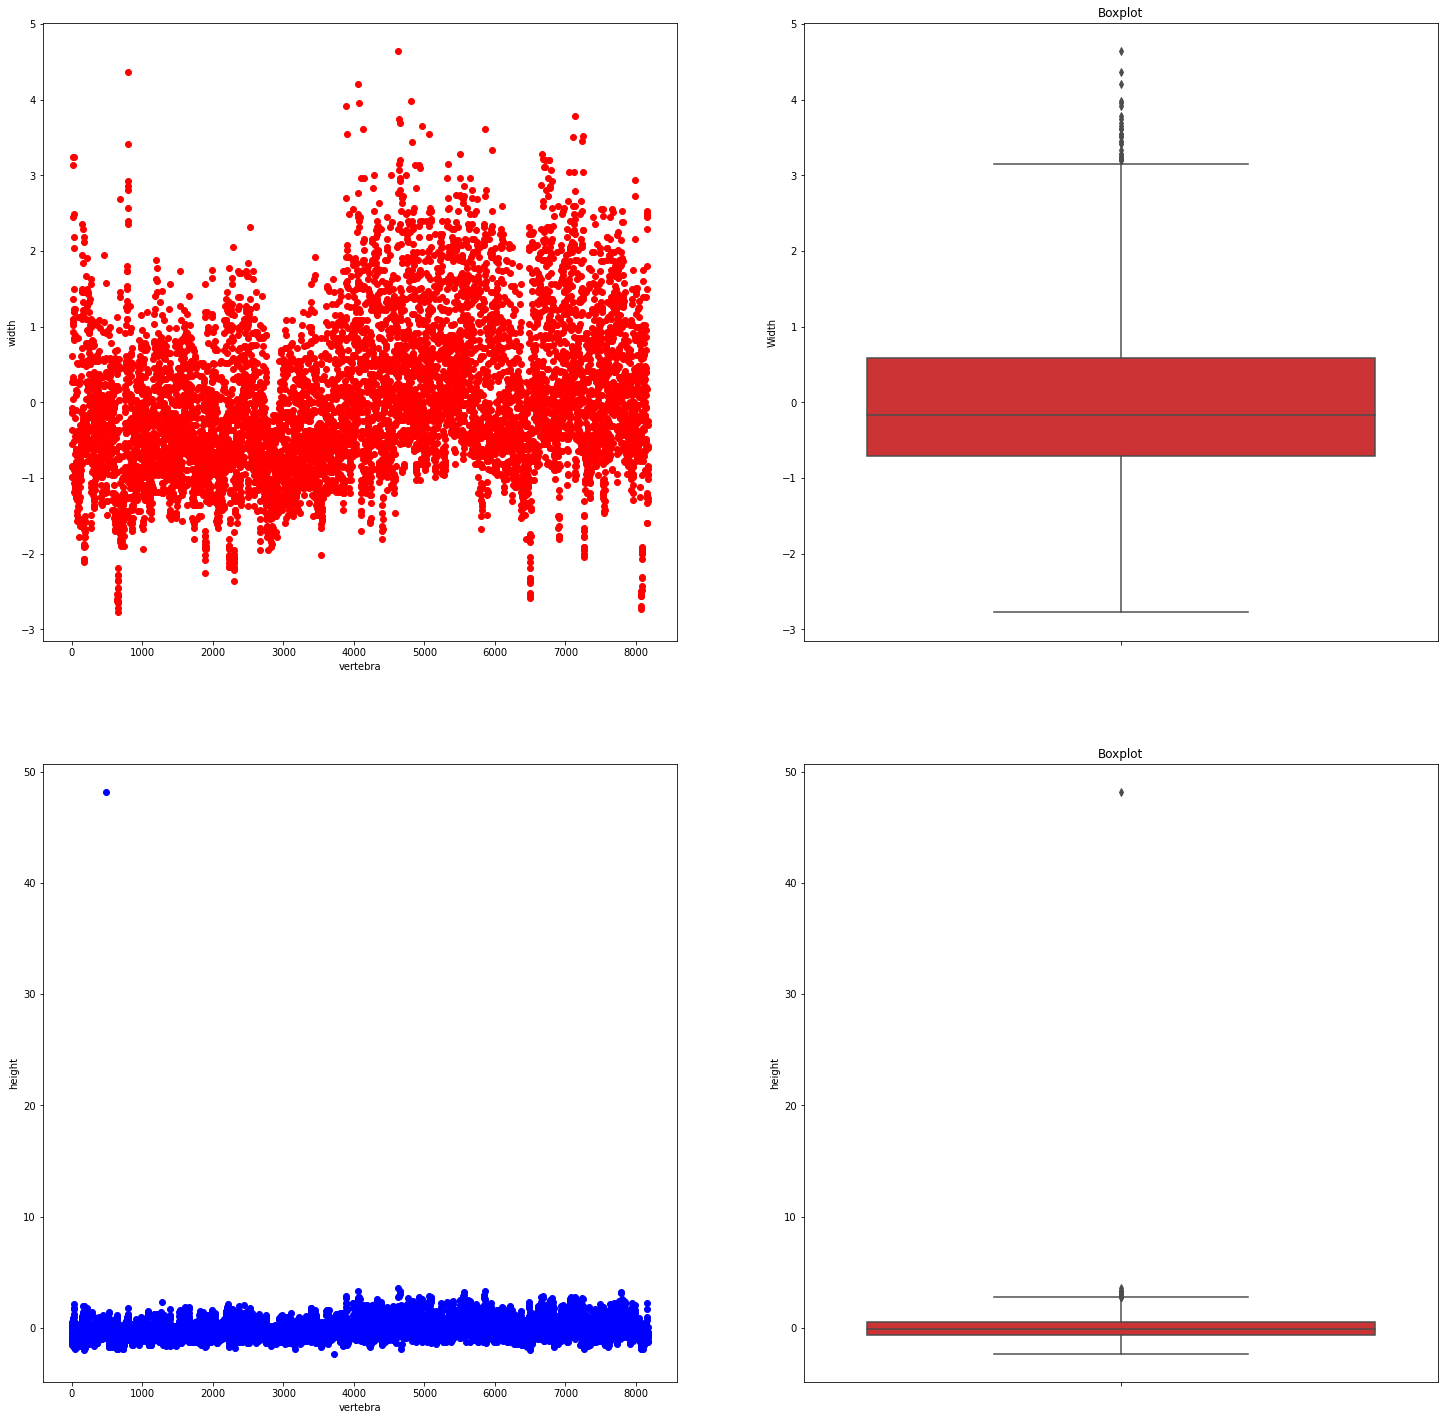

In [14]:
train_data_directory = "../boostnet_labeldata/data/training/"
test_data_directory = "../boostnet_labeldata/data/test/"
train_label_directory= "../boostnet_labeldata/labels/training/"
test_label_directory = "../boostnet_labeldata/labels/test/"



bbox_zscore(train_data_directory, train_label_directory + 'filenames.csv',
         train_label_directory + 'landmarks.csv', 'training')

#bbox_zscore(test_data_directory, test_label_directory + 'filenames.csv',
#        test_label_directory + 'landmarks.csv', 'test')

## Image pre-processing portion

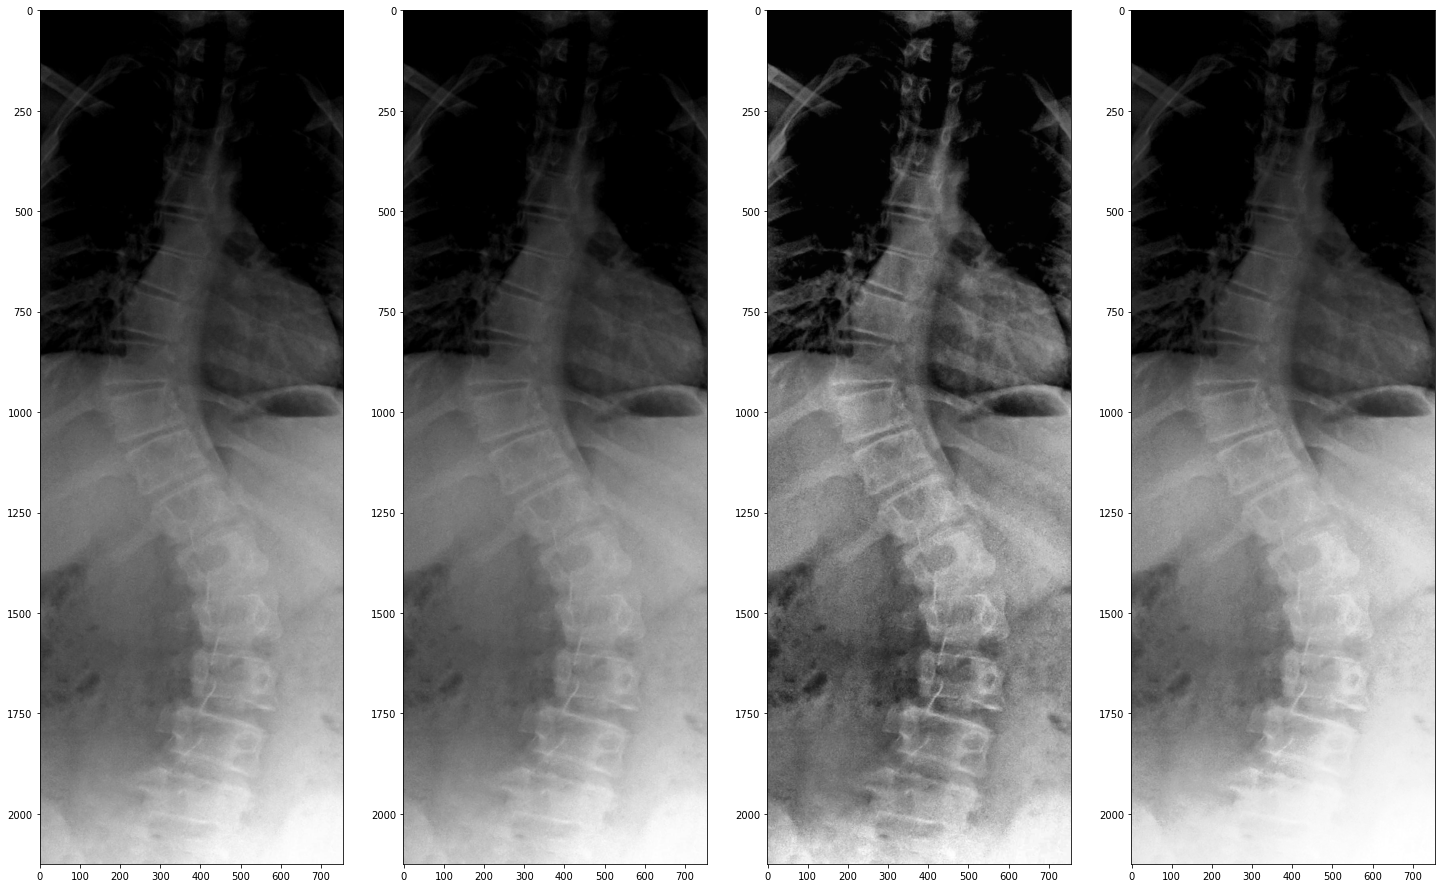

In [15]:
filename = "sunhl-1th-02-Jan-2017-162 A AP.jpg"
image_directory= "../boostnet_labeldata/data/training/"

image = image_directory+filename


img = cv2.imread(image,0)



equ = cv2.equalizeHist(img)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

#blur = cv2.bilateralFilter(img,10,75,75)
#blur= cv2.GaussianBlur(img,(7,7),2)
normalized= img/255.
normalized = (normalized-0.4847341)/0.216084388
normalized=normalized*255
    

plt.figure(1, figsize=(25,25))


plt.subplot(141)
plt.imshow(img, cmap= cm.gray)

plt.subplot (142)
plt.imshow(normalized, cmap= cm.gray)

plt.subplot (143)
plt.imshow(cl1, cmap= cm.gray)

plt.subplot (144)
plt.imshow(equ, cmap= cm.gray)


# Smoothen All Test Images

In [16]:
def smoothen(image_directory, filenames_csv, save_path):
    image_filenames= pd.read_csv(filenames_csv,header= None)
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        blur = cv2.bilateralFilter(img,15,75,75)
        #im=cv2.resize(blur,(600,1024),interpolation=cv2.INTER_AREA)
        print (blur.shape)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite (save_path+names,img)
        
    

In [17]:
test_data_directory = "../boostnet_labeldata/data/test/"
test_label_directory = "../boostnet_labeldata/labels/test/"
save_path = "resized test image/"
smoothen(test_data_directory, test_label_directory + 'filenames.csv',save_path)


(2614, 1141, 3)
(2437, 1084, 3)
(1802, 839, 3)
(1745, 865, 3)
(1901, 906, 3)
(2036, 943, 3)
(1802, 927, 3)
(1984, 964, 3)
(2057, 959, 3)
(2099, 933, 3)
(2307, 985, 3)
(2104, 1167, 3)
(2057, 1198, 3)
(2599, 1203, 3)
(2635, 1068, 3)
(2609, 1162, 3)
(2828, 1323, 3)
(2807, 1266, 3)
(2682, 1146, 3)
(2620, 1125, 3)
(2692, 1250, 3)
(2687, 1386, 3)
(2760, 1125, 3)
(2541, 1130, 3)
(2656, 1146, 3)
(2442, 1380, 3)
(1159, 427, 3)
(2599, 1078, 3)
(2401, 901, 3)
(2573, 974, 3)
(2708, 1182, 3)
(2614, 1214, 3)
(2687, 1141, 3)
(2469, 985, 3)
(1176, 728, 3)
(1314, 720, 3)
(2500, 1281, 3)
(1480, 751, 3)
(1666, 775, 3)
(1937, 906, 3)
(2552, 943, 3)
(2854, 1182, 3)
(2427, 969, 3)
(2573, 1052, 3)
(2463, 943, 3)
(2583, 1099, 3)
(2578, 906, 3)
(2515, 1021, 3)
(2552, 990, 3)
(2167, 891, 3)
(2182, 933, 3)
(2187, 1084, 3)
(2375, 1052, 3)
(2141, 1110, 3)
(2281, 1031, 3)
(2620, 912, 3)
(2552, 1005, 3)
(1221, 571, 3)
(1324, 682, 3)
(2432, 1094, 3)
(2005, 854, 3)
(2125, 974, 3)
(2333, 922, 3)
(2469, 1026, 3)
(2411, 

# Intelligent Crop #

In [18]:
def intelligent_crop(image_directory, filenames_csv, save_path):
    image_filenames= pd.read_csv(filenames_csv,header= None)
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        height =img.shape[0]
        width = img.shape[1]
        ratio = height/width
        upper_crop=0.15
        lower_crop=0.25
        print (height*0.2*(ratio/3.75),height*(1-0.21*(ratio/3.75)))
        cropped_image=img[int(height*0.2*(ratio/3.75)):int(height*(1-0.21*(ratio/3.75))),0:width]
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite (save_path+names,cropped_image)

In [19]:
test_data_directory = "../boostnet_labeldata/data/test/"
test_label_directory = "../boostnet_labeldata/labels/test/"
save_path = "test cropped/crop/"
intelligent_crop(test_data_directory, test_label_directory + 'filenames.csv', save_path)


319.39215892491967 2278.6382331288346
292.20019680196805 2130.1897933579335
206.417417560588 1585.2617115613825
187.74720616570326 1547.8654335260117
212.73295069904347 1677.6304017660045
234.44586779780843 1789.8318388123012
186.8222366055376 1605.8366515641856
217.77349930843704 1755.337825726141
235.31450816823082 1809.9197664233577
251.85000357270457 1834.55749624866
288.17591878172595 2004.4152852791879
202.31092830619824 1891.5735252784918
188.36946021146358 1859.2120667779634
299.4647159878083 2284.562048212801
346.72784019975035 2270.935767790262
312.42138841078605 2280.9575421686745
322.401975308642 2489.4779259259262
331.9325539757767 2458.4708183254343
334.7585340314136 2330.5035392670156
325.4234074074074 2278.305422222222
309.19953066666665 2367.3404928
277.8246849446849 2395.284080808081
361.1306666666666 2380.8128
304.7401061946903 2221.0228884955754
328.2995229784759 2311.2855008726006
230.4681739130435 2200.008417391304
167.77904761904762 982.832
334.1892888064317 2248

# Normalize the images

In [64]:
def z_normalize(image):
    print (image.shape)
    mean = image.mean(axis=(0,2),dtype='float64')
    std =  image.std(axis=(0,2), dtype='float64')
    print (mean,std)
    return ((image-mean)/std,mean)

In [65]:
def find_normalized_max_min(image_directory, filenames_csv, save_path, split_type= 'training'):
    
    
    image_filenames= pd.read_csv(filenames_csv,header= None)
    image_min=[]
    image_max=[]
    image_mean=[]
    
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        print (names)
        z_norm_img,mean=z_normalize(img) 
        # convert pixel values in range[0,255]
        #norm_image = cv2.normalize(z_norm_img, None, alpha = np.min(z_norm_img), beta = np.max(z_norm_img),
        #                           norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        if split_type not in os.listdir(save_path):
            os.mkdir(save_path+split_type)
        image_min.append(np.min(z_norm_img))
        image_max.append(np.max(z_norm_img))
        print(mean)
        image_mean.append(mean)
        
        #cv2.imwrite(save_path+split_type+'/'+names,z_norm_img)
    print(np.mean(np.array(image_mean),axis=0))
    image_min=np.array(image_min)
    image_max=np.array(image_max)
    return (np.max(image_max),np.min(image_min))
        
        
    
    
    
    
    

In [66]:
def save_normalize_image(image_directory, filenames_csv, save_path,maximum,minimum, split_type= 'training'):
    
    
    image_filenames= pd.read_csv(filenames_csv,header= None)
    image_min=[]
    image_max=[]
    
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        print (names)
        z_norm_img=z_normalize(img) 
        img_viz = ((z_norm_img-(minimum))/(maximum-minimum))*255
        img_viz= img_viz.astype(int)
        # convert pixel values in range[0,255]
        #norm_image = cv2.normalize(z_norm_img, None, alpha = np.min(z_norm_img), beta = np.max(z_norm_img),
        #                           norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        if split_type not in os.listdir(save_path):
            os.mkdir(save_path+split_type)
        
        
        
        cv2.imwrite(save_path+split_type+'/'+names,img_viz)
    

In [67]:
def combine_all_images(image_directory,filenames_csv):
    image_filenames= pd.read_csv(filenames_csv)
    #print (image_filenames)
    images=[]
    for i, names in enumerate(image_filenames['image_id'] ):
        img = cv2.imread(image_directory+names,0)
        img=img/255.
        images.append(img)
        #print (names)
    images = np.array(images)
    normalized = z_normalize(images)
        
    
    

In [68]:
train_data_directory = "training_patch_images/"
val_data_directory = "test_patch_images/"

combine_all_images(train_data_directory, 'training_patches_gnd.csv')
#combine_all_images(test_data_directory, 'test_patches_gnd.csv')

(3,)


C:\Users\Mohammed\anaconda3\envs\SpineCurvEst\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


AxisError: axis 2 is out of bounds for array of dimension 1

In [ ]:
train_data_directory = "../boostnet_labeldata/data/training/"
val_data_directory = "../boostnet_labeldata/data/test/"
train_label_directory= "../boostnet_labeldata/labels/training/"
val_label_directory = "../boostnet_labeldata/labels/test/"
save_path = "normalized images/"


(maximum,minimum)= find_normalized_max_min(train_data_directory, train_label_directory + 'filenames.csv', save_path, 'training')
#save_normalize_image(train_data_directory, train_label_directory + 'filenames.csv' , save_path, maximum, minimum, 'training')


#(x,y)= normalize_image(val_data_directory,os.path.join(val_label_directory,'filenames.csv'),save_path, 'val')
print (maximum,minimum)

## Add Gaussian Noise

In [3]:
'''parameters
----------
image : ndarray
    Input image data. Will be converted to float.
mode : str
    One of the following strings, selecting the type of noise to add:

    'gauss'     Gaussian-distributed additive noise.
    'poisson'   Poisson-distributed noise generated from the data.
    's&p'       Replaces random pixels with 0 or 1.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.'''


import numpy as np
import os
import cv2
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 255
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        cv2.normalize(noisy, noisy, 0, 255, cv2.NORM_MINMAX, dtype=-1)
        noisy = noisy.astype(np.uint8)
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy

    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy

(2125, 755, 3)


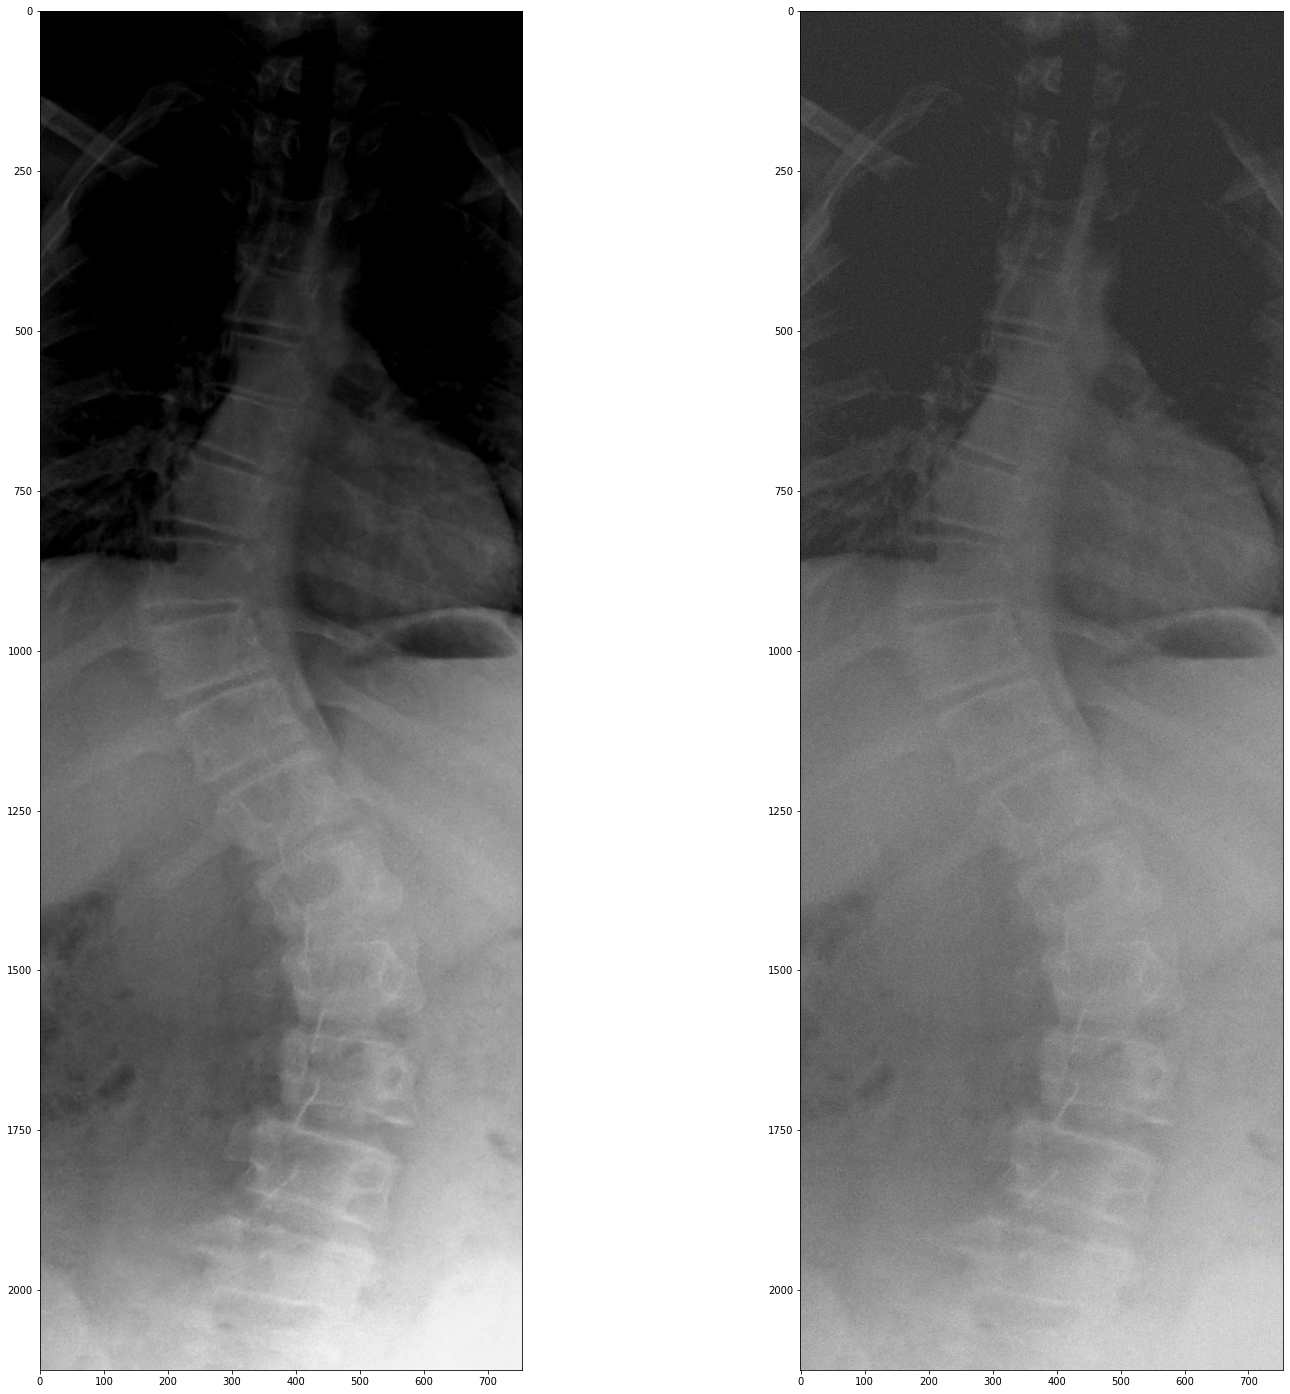

In [4]:
filename = "sunhl-1th-02-Jan-2017-162 A AP.jpg"
image_directory= "../boostnet_labeldata/data/training/"


image = image_directory+filename


img = cv2.imread(image)
print (img.shape)

gau_img= noisy('gauss',img)
plt.figure(1, figsize=(25,25))


plt.subplot(121)

plt.imshow(img[:,:,::-1])

plt.subplot(122)

plt.imshow(gau_img[:,:,::-1])



C:\Users\Mohammed\anaconda3\envs\SpineCurvEst\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Mohammed\anaconda3\envs\SpineCurvEst\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


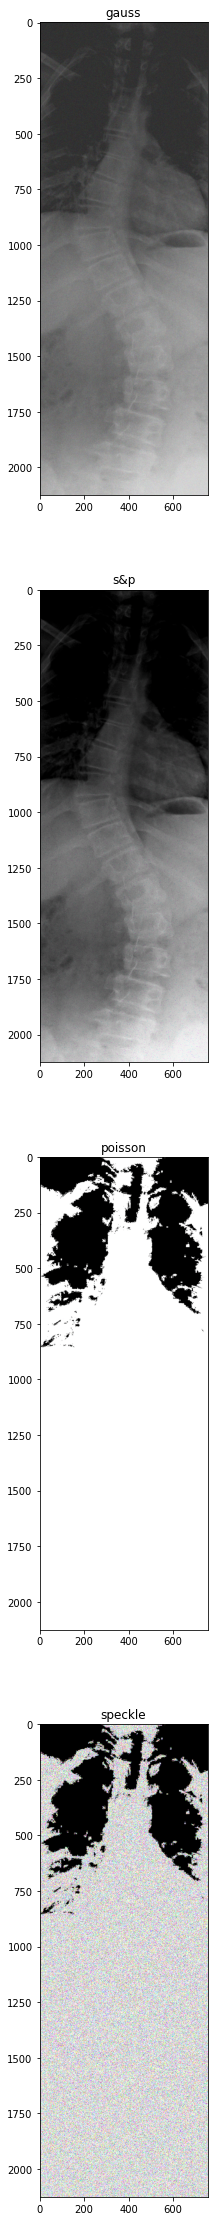

In [21]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(80,40))

gau_img= noisy('gauss',img)
ax1.set_title('gauss')
ax1.imshow(gau_img, cmap='gray')

sp_img= noisy('s&p',img)
ax2.set_title('s&p')
ax2.imshow(sp_img, cmap='gray')

poisson_img = noisy('poisson',img)
ax3.set_title('poisson')
ax3.imshow(poisson_img, cmap='gray')

speckle_img= noisy('speckle',img)
ax4.set_title('speckle')
ax4.imshow(speckle_img, cmap='gray')



In [56]:
def gauss_all_img(image_directory, filenames_csv, save_path):
    image_filenames= pd.read_csv(filenames_csv,header= None)
    for i, names in enumerate(image_filenames.iloc[:,0]):

        img = cv2.imread(image_directory+names)
        gau_img= noisy('gauss',img)
        cv2.imwrite (save_path+'gauss_'+names,gau_img)

In [57]:
#ROOT_PATH = "C:/Users/Brinda Khanal/Documents/Bidur Git Repo/Spine_Challenge/Object detection/"
train_data_directory = "../boostnet_labeldata/data/training/"
val_data_directory = "../boostnet_labeldata/data/test/"
train_label_directory= "../boostnet_labeldata/labels/training/"
val_label_directory = "../boostnet_labeldata/labels/test/"
save_path_train = "gaussian_noise/train/"
save_path_val = "gaussian_noise/val/"

gauss_all_img(train_data_directory,os.path.join(train_label_directory,'filenames.csv'),save_path_train)
gauss_all_img(val_data_directory,os.path.join(val_label_directory,'filenames.csv'),save_path_val)









In [60]:
import tensorflow as tf
# Build a dataflow graph.
v = tf.placeholder(tf.float32, [1, None, None, 3], name='x-input')
mean,var=tf.nn.moments(v,(1,2))
print (mean.dtype)
inputs= (v-mean)/tf.sqrt(var)
with tf.Session() as sess:
    print(sess.run(inputs, feed_dict={v:[[[[1, 4, 3],[1, 2, 3]],[[7,2,3],[1,2,2]]]]}))
    

<dtype: 'float32'>
[[[[-0.5773503   1.7320509   0.57735026]
   [-0.5773503  -0.57735026  0.57735026]]

  [[ 1.7320509  -0.57735026  0.57735026]
   [-0.5773503  -0.57735026 -1.7320509 ]]]]


In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import datasets, layers, models

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

def customLossThatWorks():
    return tf.keras.losses.sparse_categorical_crossentropy

# def customLoss(y_true, y_pred):
#     return K.sparse_categorical_crossentropy(y_true, y_pred)

# def customLoss():
#     def loss(y_true,y_pred):
#         return K.sparse_categorical_crossentropy(y_true, y_pred)
#     return loss
    
# def customLoss():
#     def loss(y_true,y_pred):
#         return tf.keras.losses.sparse_categorical_crossentropy(y_true,y_pred)
#     return loss

# copied from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/keras/losses.py#L867
def customLoss(y_true, y_pred):
    y_true= tf.Print(y_true,[y_true],"y_true=")
    y_pred= tf.Print(y_pred,[y_pred],"y_pred=")
    return K.sparse_categorical_crossentropy(
      y_true, y_pred)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss=customLoss, optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])
model.fit(train_images, train_labels, epochs=1)



Epoch 1/1
60000/60000 [==============================] - 2874s 48ms/step - loss: 0.1504 - acc: 0.0992 - categorical_accuracy: 0.0992


ValueError: Parent directory of d40a34821081 doesn't exist, can't save.

C:\Users\Mohammed\anaconda3\envs\SpineCurvEst\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
C:\Users\Mohammed\anaconda3\envs\SpineCurvEst\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


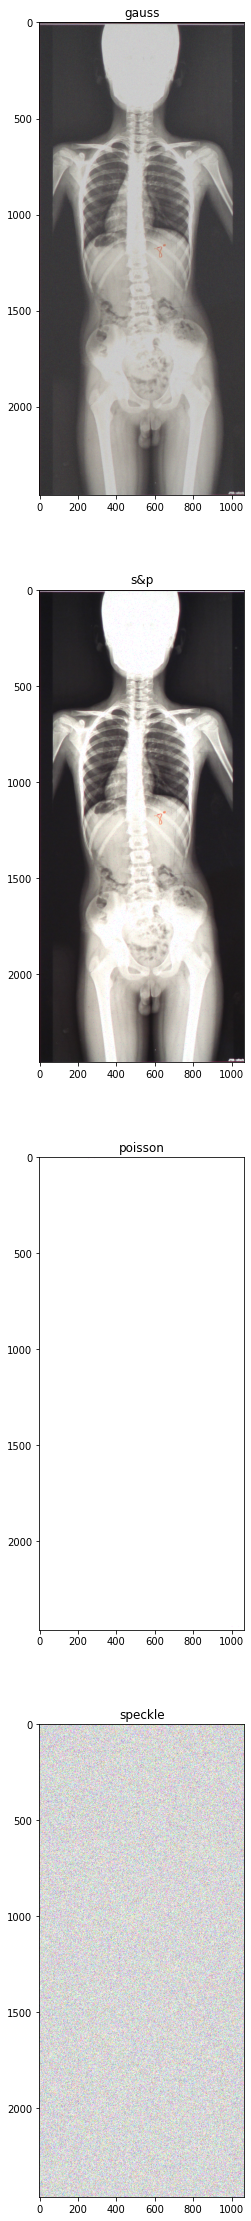